<a href="https://colab.research.google.com/github/SaraZachi/Modelo-Previsao_COVID19/blob/main/Notebooks/03_Modelo_de_valida%C3%A7%C3%A3o_PE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3.1. Primeiros passos**

In [ ]:
# Importando Bibliotecas
import pandas as pd
from pandas.plotting import autocorrelation_plot

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

from sklearn.metrics import mean_absolute_error

In [ ]:
# Removendo avisos
import warnings
warnings.filterwarnings('ignore')

# Paremetros gerais para os gráficos
mpl.rcParams['font.size'] = 18
mpl.rcParams['figure.figsize'] = (12,8)

#setting charts style
sns.set()

In [ ]:
# Importando Dataframe
url = 'https://github.com/SaraZachi/BootCamp-Data-Science---Alura/blob/main/Projeto%20-%20M%C3%B3dulo%203%20-%20S%C3%A9ries%20Temporais/dados/caso_full.zip?raw=true'
dados = pd.read_csv(url, sep = ',', compression='zip')
dados.head()

,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
0,Rio Branco,1200401.0,2020-03-17,202012,413418.0,407319.0,False,False,3,0.72566,2020-03-17,0.0,0,1,city,AC,3,0
1,NaN,12.0,2020-03-17,202012,894470.0,881935.0,False,False,3,0.33539,2020-03-17,0.0,0,1,state,AC,3,0
2,Rio Branco,1200401.0,2020-03-18,202012,413418.0,407319.0,False,False,3,0.72566,2020-03-18,0.0,0,2,city,AC,0,0
3,NaN,12.0,2020-03-18,202012,894470.0,881935.0,False,False,3,0.33539,2020-03-18,0.0,0,2,state,AC,0,0
4,Rio Branco,1200401.0,2020-03-19,202012,413418.0,407319.0,False,False,4,0.96754,2020-03-19,0.0,0,3,city,AC,1,0


* Fonte: Secretarias de Saúde das Unidades Federativas, dados tratados por Álvaro Justen e equipe de voluntários [Brasil.IO](https://brasil.io/home/)
* Brasil.IO: boletins epidemiológicos da COVID-19 por município por dia, disponível em: https://brasil.io/dataset/covid19/caso_full/ (última atualização: 02 de Julho de 2021, acesso em 02 de Julho de 2021).

In [ ]:
# Formatando a coluna 'date' para o formato: '%Y-%m-%d' == 'year-months-days'
dados['date'] = pd.to_datetime(dados['date'], format='%Y-%m-%d')

In [ ]:
# Separando as informações de Pernambuco (PE)
df_pe = dados.query('state == "PE"')
df_pe

,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
1138460,Recife,2611606.0,2020-03-12,202011,1653461.0,1645727.0,False,False,2,0.12096,2020-03-12,0.0000,0,1,city,PE,2,0
1138461,NaN,26.0,2020-03-12,202011,9616621.0,9557071.0,False,False,2,0.02080,2020-03-12,0.0000,0,1,state,PE,2,0
1138462,Recife,2611606.0,2020-03-13,202011,1653461.0,1645727.0,False,False,2,0.12096,2020-03-13,0.0000,0,2,city,PE,0,0
1138463,NaN,26.0,2020-03-13,202011,9616621.0,9557071.0,False,False,2,0.02080,2020-03-13,0.0000,0,2,state,PE,0,0
1138464,Importados/Indefinidos,NaN,2020-03-14,202011,NaN,NaN,False,False,1,NaN,2020-03-14,0.0000,0,1,city,PE,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1217656,Vitória de Santo Antão,2616407.0,2021-06-20,202125,139583.0,138757.0,False,True,6482,4643.83199,2021-06-19,0.0427,277,440,city,PE,0,0
1217657,Xexéu,2616506.0,2021-06-20,202125,14757.0,14725.0,False,True,475,3218.81141,2021-06-19,0.0484,23,424,city,PE,0,0
1217658,Água Preta,2600401.0,2021-06-20,202125,37082.0,36771.0,False,True,1442,3888.67914,2021-06-19,0.0409,59,421,city,PE,0,0
1217659,Águas Belas,2600500.0,2021-06-20,202125,43686.0,43443.0,False,True,1595,3651.05526,2021-06-19,0.0207,33,415,city,PE,0,0


# **3.2. Explorando dados**

## **3.2.1. Número total de casos e óbitos por mês** 

Vamos iniciar explorando o número de casos e óbitos de Pernambuco (PE)

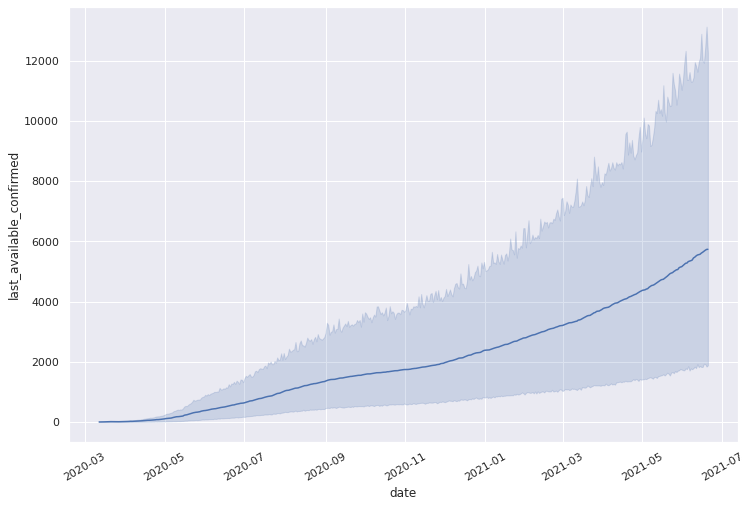

In [ ]:
# Line plot do número de casos por data em PE
sns.lineplot(x='date', y='last_available_confirmed', data=df_pe)
plt.xticks(rotation=30)
plt.show()

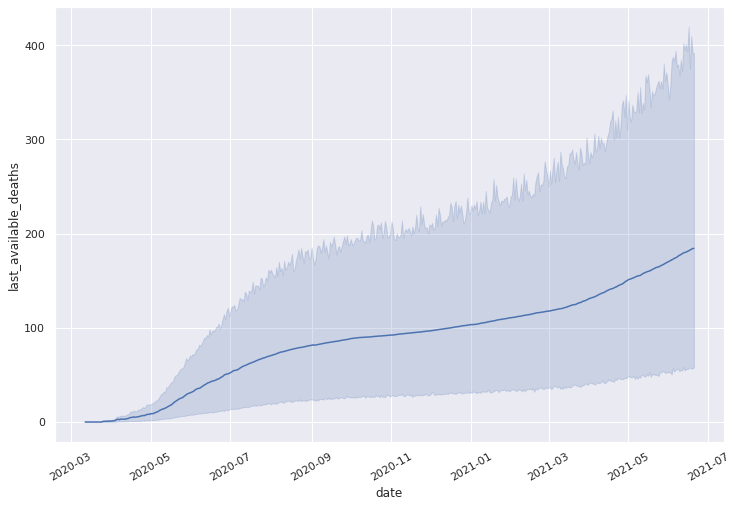

In [ ]:
# Line plot do número de óbitos por data em PE
sns.lineplot(x='date', y='last_available_deaths', data=df_pe)
plt.xticks(rotation=30)
plt.show()

Os gráficos acima nos mostram uma série temporal na qual percebemos que o número de casos, ou óbitos, aumenta em função do tempo, apresentando uma pequena queda entre novembro de 2020 e abril de 2021. 

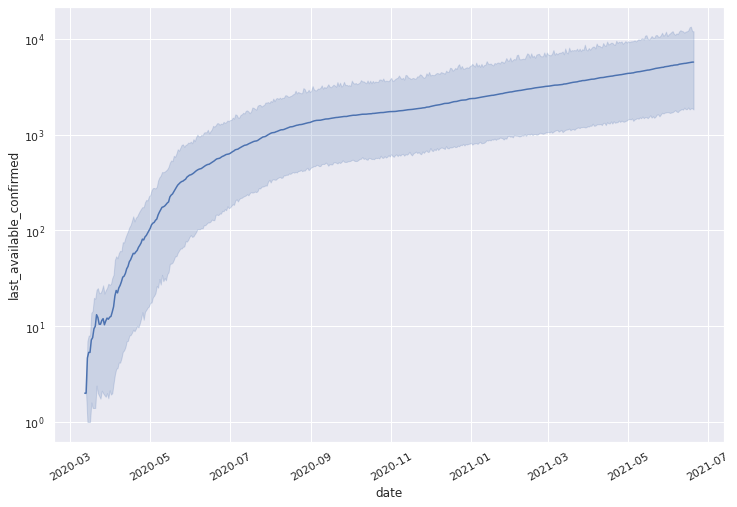

In [ ]:
# Plot monolog do número de casos
sns.lineplot(x='date', y='last_available_confirmed', data=df_pe)
mpl.pyplot.yscale('log')

plt.xticks(rotation=30)
plt.show()

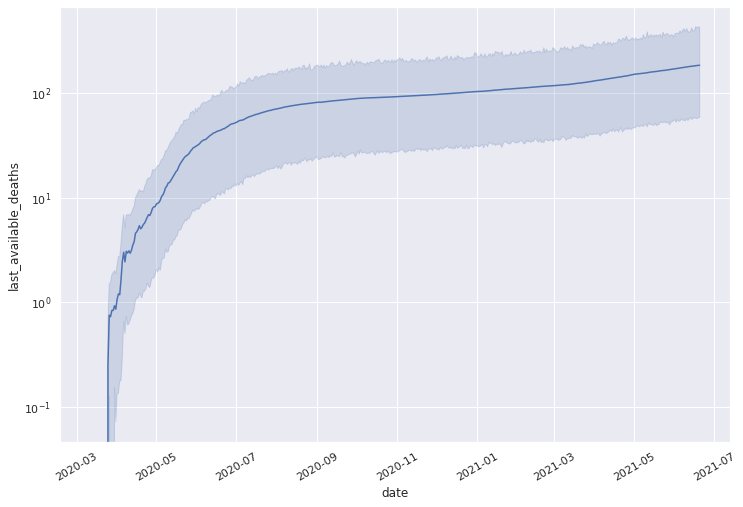

In [ ]:
# Plot monolog do numero de óbitos
sns.lineplot(x='date', y='last_available_deaths', data=df_pe)
mpl.pyplot.yscale('log')

plt.xticks(rotation=30)
plt.show()

Com o gráfico monolog do numero de casos, podemos observar com mais clareza a taxa de crescimento do número de casos em função do ano/mês. A partir de Abril de 2020 percebemos um crescimento exponencial do número de casos, que se torna mais constante a partir de junho de 2020. No entanto, a partir de novembro de 2020, podemos observar que a taxa de crescimento aumenta cada vez mais. O gráfico monolog do número de óbitos tem uma tendência semelhante ao gráfico do número de casos. No entanto, o aumento do número de mortes a partir de novembro de 2020 é um pouco mais sutil. Mesmo com a campanha de vacinação contra o COVID-19 em Pernambuco, que iniciou em [18 de janeiro 2021](https://www.pecontracoronavirus.pe.gov.br/), o número de casos continuou crescendo.

## **3.2.2. Relação entre os casos e óbitos novos**

Vamos então averiguar se há uma correlação entre o número de casos e óbitos novos

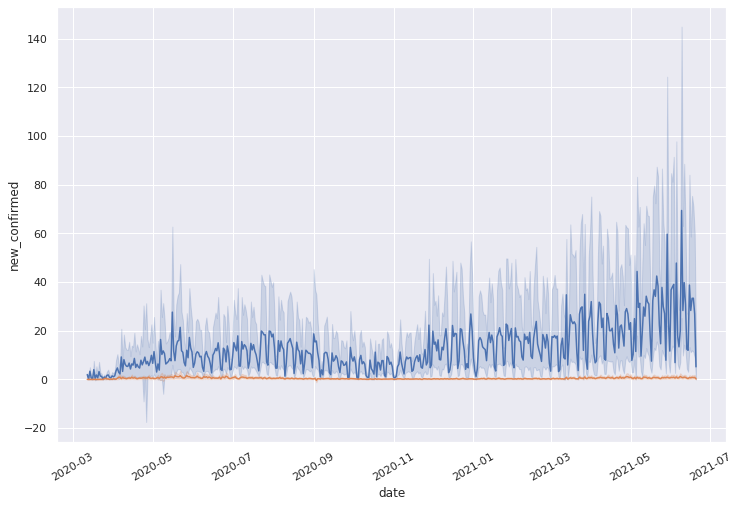

In [ ]:
# plot do número de novos casos e mortes de COVID-19 em PE por mês
sns.lineplot(x='date', y='new_confirmed', data=df_pe)
sns.lineplot(x='date', y='new_deaths', data=df_pe)

plt.xticks(rotation=30)
plt.show()

No gráfico acima há uma grande quantia de dados, dificultando a vizualização de informações que o gráfico possa mostrar. Deste modo, vamos observar apenas os dados de 2020:

In [ ]:
# Adicionando ao df uma coluna 'year' com apenas o ano das informações da coluna 'date'
# no df dos dados de COVID de PE
df_pe['year'] = pd.DatetimeIndex(df_pe['date']).year

# Criando um df de 2020
df_pe_2020 = df_pe.query('year==2020')

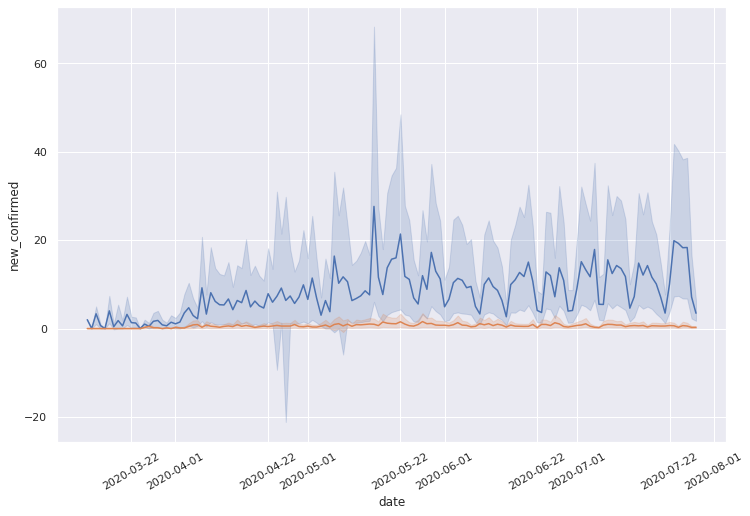

In [ ]:
# plot do número de novos casos e mortes de COVID-19 em PE no ano de 2020
sns.lineplot(x='date', y='new_confirmed', data=df_pe_2020[:18000])
sns.lineplot(x='date', y='new_deaths', data=df_pe_2020[:18000])

plt.xticks(rotation=30)
plt.show()

Perceba, no gráfico acima, que, na maioria dos casos, ocorre uma queda no número de óbitos quando ocorre uma queda no número de casos. O mesmo se aplica aos picos de número de casos e óbitos registrados. No entanto, em alguns casos, ocorre também de o número de casos aumentar e o número de óbitos subir ou permanecer constante, ou vice-versa.

Vereificando o tipo de relação entre o número de óbitos e o número de casos novos para COVID em SP, percebemos que não há uma correlação perfeitamente linear entre ambos. No entanto, a correlação entre ambos parece mais clara em alguns pontos. Além disso, podemos perceber, no geral, uma correlação crescente:

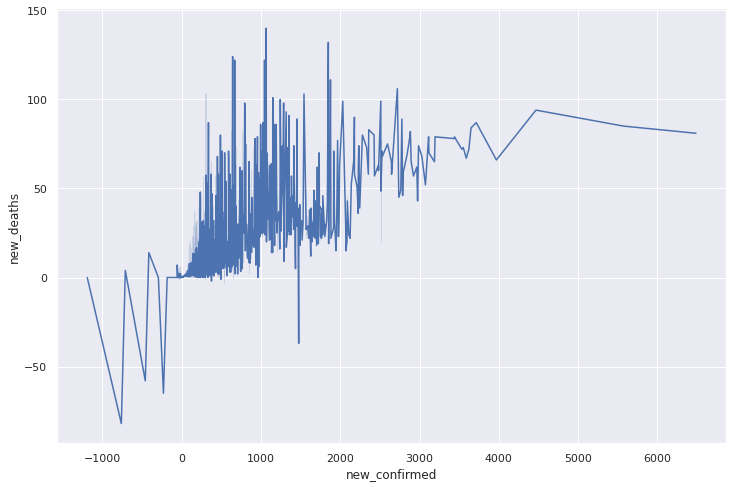

In [ ]:
sns.lineplot(x='new_confirmed', y='new_deaths', data=df_pe)

## **3.2.3. Sasonalidade**

Vimos acima que não há uma correlação perfeita ou sasonalidade entre o número de casos e óbitos novos. Iremos então averiguar se há uma sasonalidade por mês ou semanas no número de casos novos.

In [ ]:
# Adicionando ao df uma coluna 'month' com apenas o ano das informações da coluna 'date'
# no df dos dados de COVID do PA
df_pe['month'] = pd.DatetimeIndex(df_pe['date']).month
df_pe['day'] = pd.DatetimeIndex(df_pe['date']).day

# Criando dfs de jan e fev de 2020
df_pe_abr2021 = df_pe.query('month==4 & year==2021')
df_pe_mai2021 = df_pe.query('month==5 & year==2021')

#  Agrupando os dfs pelos dias do mês
df_pe_abr2021 = df_pe_abr2021.groupby(['day']).sum()
df_pe_mai2021 = df_pe_mai2021.groupby(['day']).sum()

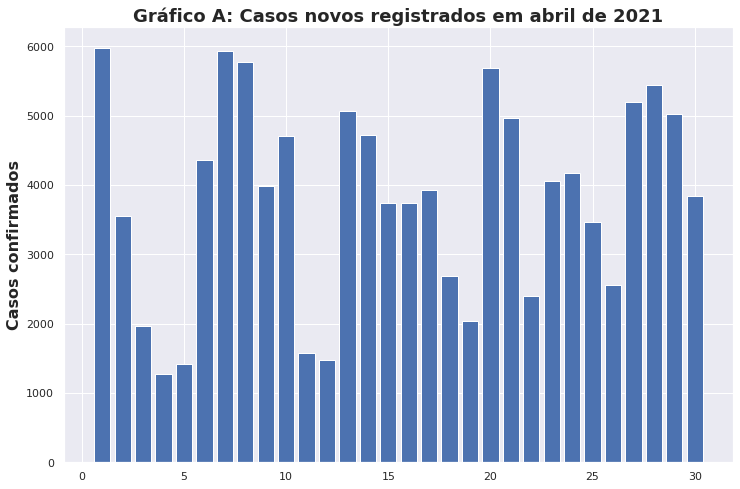

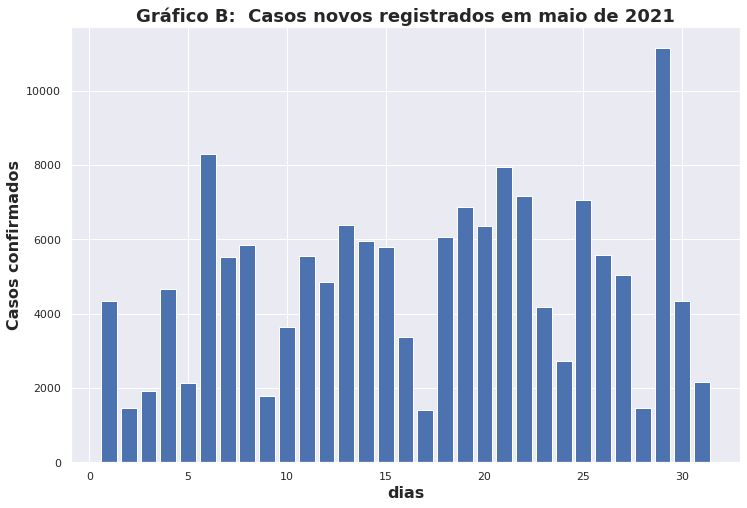

In [ ]:
plt.bar(np.linspace(1,30,30), df_pe_abr2021['new_confirmed'])
plt.ylabel('Casos confirmados', fontsize = 16, fontweight = 'bold')
plt.title('Gráfico A: Casos novos registrados em abril de 2021', fontsize=18, fontweight='bold')
plt.show()

plt.bar(np.linspace(1,31,31),df_pe_mai2021['new_confirmed'])
plt.xlabel('dias', fontsize = 16, fontweight = 'bold')
plt.ylabel('Casos confirmados', fontsize = 16, fontweight = 'bold')
plt.title('Gráfico B:  Casos novos registrados em maio de 2021', fontsize=18, fontweight='bold')
plt.show()

Em abril (Gráfico A), o dia 2 foi um feriado (Sexta-Feira Santa) e os dias 4, 11, 18 e 25 foram os domingos do mês. Em maio (Gráfico B), tivemos o feriado do dia 1 (dia-do-trabalhor) e os domingos foram os dias 9, 16, 23 e 30. Dito isso, repare nos gráficos acima que o número de casos confirmados diminui a cada 6 e 7 dias. Deste modo, podemos dizer que a notificação de casos de COVID-19 é menor aos domingos, segundas e feriados em ambos os mêses.

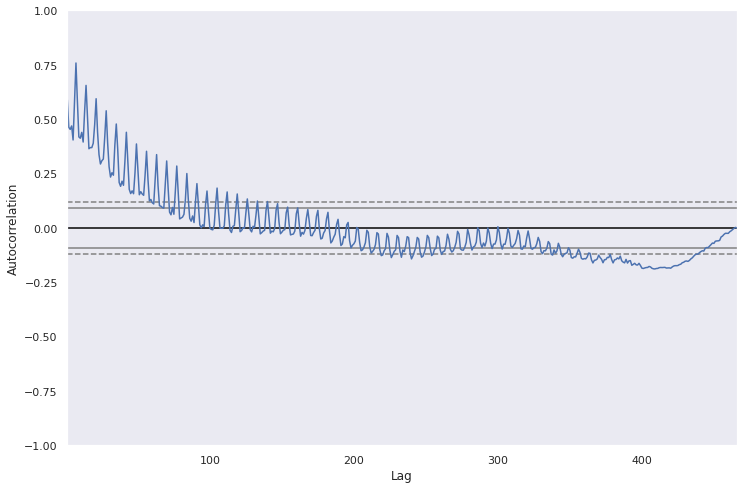

In [ ]:
df_pe_sum = df_pe.groupby(['date']).sum()
autocorrelation_plot(df_pe_sum['new_confirmed'])

No gráfico acima podemos perceber alguns pícos muito altos de autocorrelação. Estes picos nos mostram que há uma dependência temporal entre esses dados, são comparáveis em relação ao tempo, nos indicando uma sasonalidade. Do mesmo modo, ao final da linha, onde os resultados estão muito próximos de zero, os dados não são mais comparáveis temporalmente no início. Ou seja, a correlação entre os dados diminui em função do tempo.

# **3.3. Primeiras previsões**

Sabemos, portanto, que há uma sasonalidade no número de casos novos. Deste modo, vamos realizar nossa primeira previsão criando um df com uma coluna da data e outra do número de casos novos agrupados por ano, mês e dia.

In [ ]:
# Df da soma dos dados por dia
dados_pe = dados.query('state == "PE"')
dados_pe_sum = dados_pe.groupby(['date']).sum()
dados_pe_sum = dados_pe_sum.reset_index()

dados_pe_sum['year'] = pd.DatetimeIndex(dados_pe_sum['date']).year
dados_pe_sum['month'] = pd.DatetimeIndex(dados_pe_sum['date']).month
dados_pe_sum['day'] = pd.DatetimeIndex(dados_pe_sum['date']).day

# Novo df com apenas as colunas das datas (date) e novos casos confirmados (new_confirmed)
df = pd.DataFrame()
df['ds'] = dados_pe_sum['date']
df['y'] = dados_pe_sum['new_confirmed']
df.head()

,ds,y
0,2020-03-12,4
1,2020-03-13,0
2,2020-03-14,10
3,2020-03-15,2
4,2020-03-16,0


Vamos agora realizar os testes com o prophet para determinarmos nosso modelo de previsão

In [ ]:
# Modelo e fitting
modelo = Prophet()
modelo.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# Dataframe de previsão
dataframefuturo = modelo.make_future_dataframe(periods=20)
previsao = modelo.predict(dataframefuturo)
previsao.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-12,260.036175,-578.619978,2140.382799,260.036175,260.036175,511.204878,511.204878,511.204878,511.204878,511.204878,511.204878,0.0,0.0,0.0,771.241052
1,2020-03-13,274.815577,-780.028538,1827.230243,274.815577,274.815577,225.817519,225.817519,225.817519,225.817519,225.817519,225.817519,0.0,0.0,0.0,500.633096
2,2020-03-14,289.594980,-611.366172,2155.824379,289.594980,289.594980,519.601899,519.601899,519.601899,519.601899,519.601899,519.601899,0.0,0.0,0.0,809.196879
3,2020-03-15,304.374383,-1823.974157,871.075888,304.374383,304.374383,-829.244628,-829.244628,-829.244628,-829.244628,-829.244628,-829.244628,0.0,0.0,0.0,-524.870245
4,2020-03-16,319.153785,-2448.670566,490.639755,319.153785,319.153785,-1278.145598,-1278.145598,-1278.145598,-1278.145598,-1278.145598,-1278.145598,0.0,0.0,0.0,-958.991813


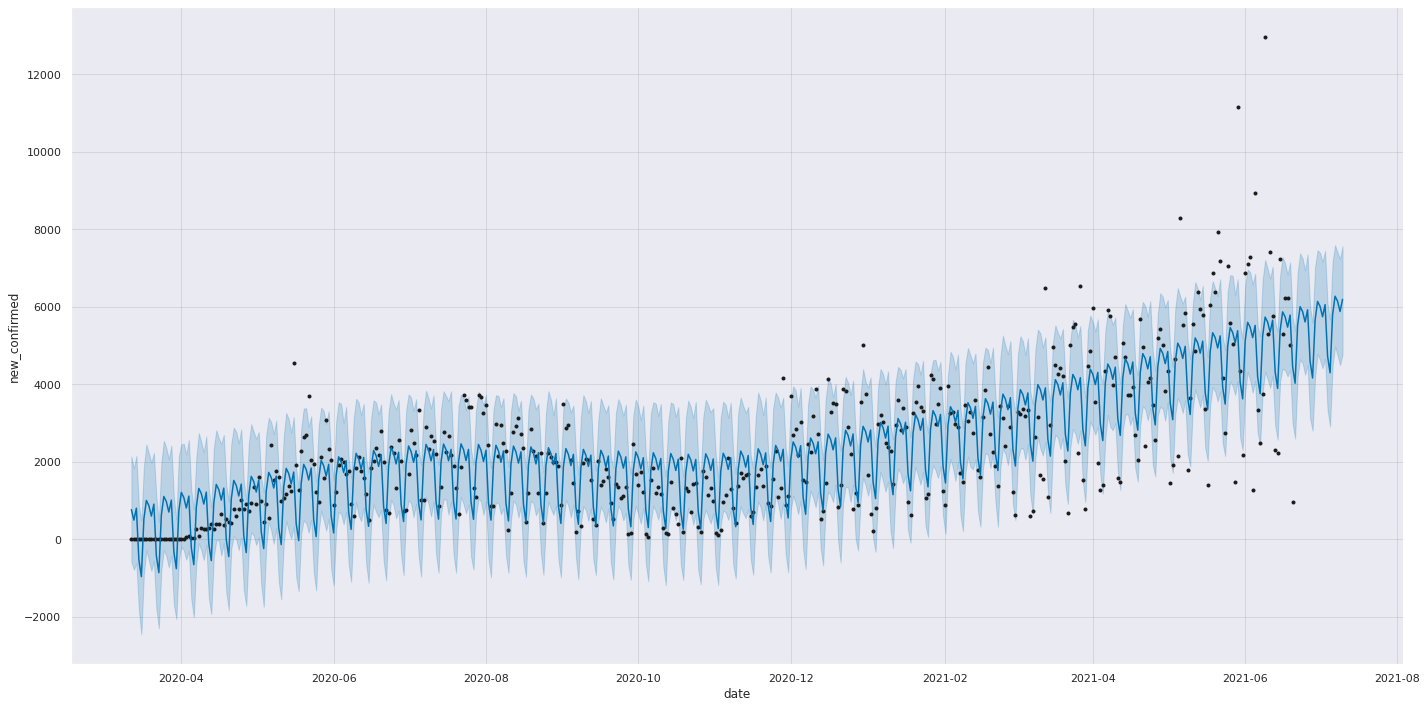

In [ ]:
# Gráfico do df de previsão
modelo.plot(previsao, xlabel='date', ylabel='new_confirmed', figsize=(20,10));

Os pontinhos pretos no nosso modelo são os dados reais do número de casos novos de COVID. No gráfico acima, o prophet buscou ajustar o modelo de previsão à esses dados. O modelo sugerido é a linha azul escura. Iremos então verificar as tendências sugeridas em nosso modelo através do plot_components:

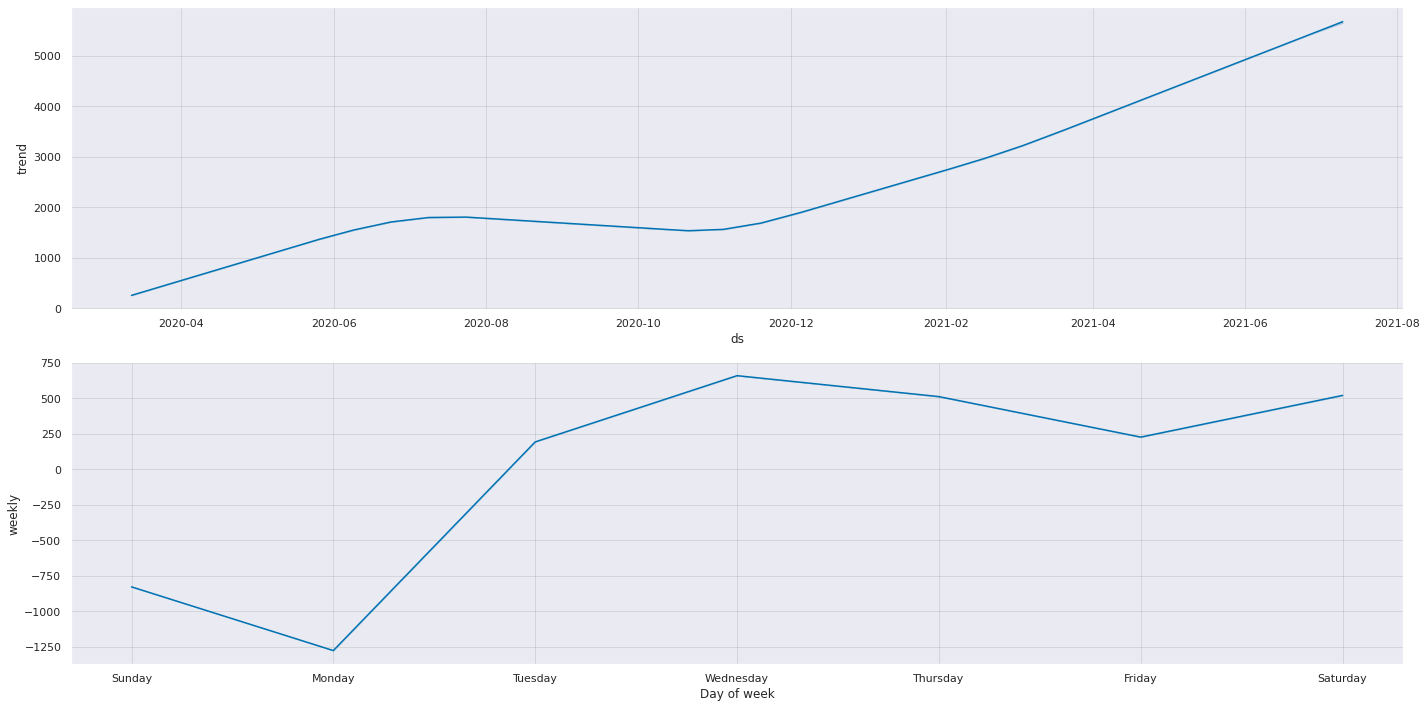

In [ ]:
# Componentes do modelo de previsão
modelo.plot_components(previsao, figsize=(20,10));

Como podemos ver, os componente do nosso modelo de previsão sugerem duas tendencias, uma geral (de abril de 2020 a junho de 2021) e uma semanal. A semanal sugere o mesmo padrão observado nos gráficos dos meses de abril e maio de 2021 realizados anteriormente. Esse padrão também pode ser observado nos pequenos picos e quedas formados em nosso modelo de previsão. Já a tendencia geral nos mostra a tendencia do crescimento e diminuição geral do número de casos registrados no decorrer do tempo.

## **3.3.1. Verificando a métrica final do modelo**

O primeiro modelo identificou a tendencia semanal que vimos anteriormente. No entanto, precisamos ver se nosso modelo é aderente aos nossos dados futuros. Para isso, vamos dividir nosso banco de dados em dados de treino e validação, para que possamos verificar a métrica final do modelo de previsão. 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      466 non-null    datetime64[ns]
 1   y       466 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 7.4 KB


vimos acima que nosso df possui 460 linhas. Então, vamos tomar para nossos dados de março de 2020 a abril de 2021:

In [ ]:
# Dataframe dos dados de treino
df_treino = pd.DataFrame()
df_treino['ds'] = dados_pe_sum['date'][:409]
df_treino['y'] = dados_pe_sum['new_confirmed'][:409]
df_treino.tail()

,ds,y
404,2021-04-20,5686
405,2021-04-21,4960
406,2021-04-22,2404
407,2021-04-23,4062
408,2021-04-24,4178


Para nossos dados de validação vamos utilizar os dados dos últimos dois meses do 2021, maio e junho:

In [ ]:
# Dataframe dos dados de treino
df_valid = pd.DataFrame()
df_valid['ds'] = dados_pe_sum['date'][409:]
df_valid['y'] = dados_pe_sum['new_confirmed'][409:]
df_valid.head()

,ds,y
409,2021-04-25,3468
410,2021-04-26,2556
411,2021-04-27,5192
412,2021-04-28,5440
413,2021-04-29,5022


In [ ]:
# Modelo dos dados de treino
modelo = Prophet()
modelo.fit(df_treino)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# Dataframe de previsão dos dados de treino
dataframefuturo = modelo.make_future_dataframe(periods=52)
previsao = modelo.predict(dataframefuturo)
previsao.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-12,291.630877,-352.489239,1813.128216,291.630877,291.630877,415.591796,415.591796,415.591796,415.591796,415.591796,415.591796,0.0,0.0,0.0,707.222673
1,2020-03-13,305.796303,-507.908759,1667.992560,305.796303,305.796303,269.788664,269.788664,269.788664,269.788664,269.788664,269.788664,0.0,0.0,0.0,575.584967
2,2020-03-14,319.961729,-408.098445,1857.089098,319.961729,319.961729,364.137914,364.137914,364.137914,364.137914,364.137914,364.137914,0.0,0.0,0.0,684.099643
3,2020-03-15,334.127155,-1397.377151,888.254359,334.127155,334.127155,-623.348497,-623.348497,-623.348497,-623.348497,-623.348497,-623.348497,0.0,0.0,0.0,-289.221342
4,2020-03-16,348.292581,-1909.957413,339.106949,348.292581,348.292581,-1103.185018,-1103.185018,-1103.185018,-1103.185018,-1103.185018,-1103.185018,0.0,0.0,0.0,-754.892437


Agora vamos plotar nosso modelo com os dados de treino e utilizar os dados de validação para validar este modelo:

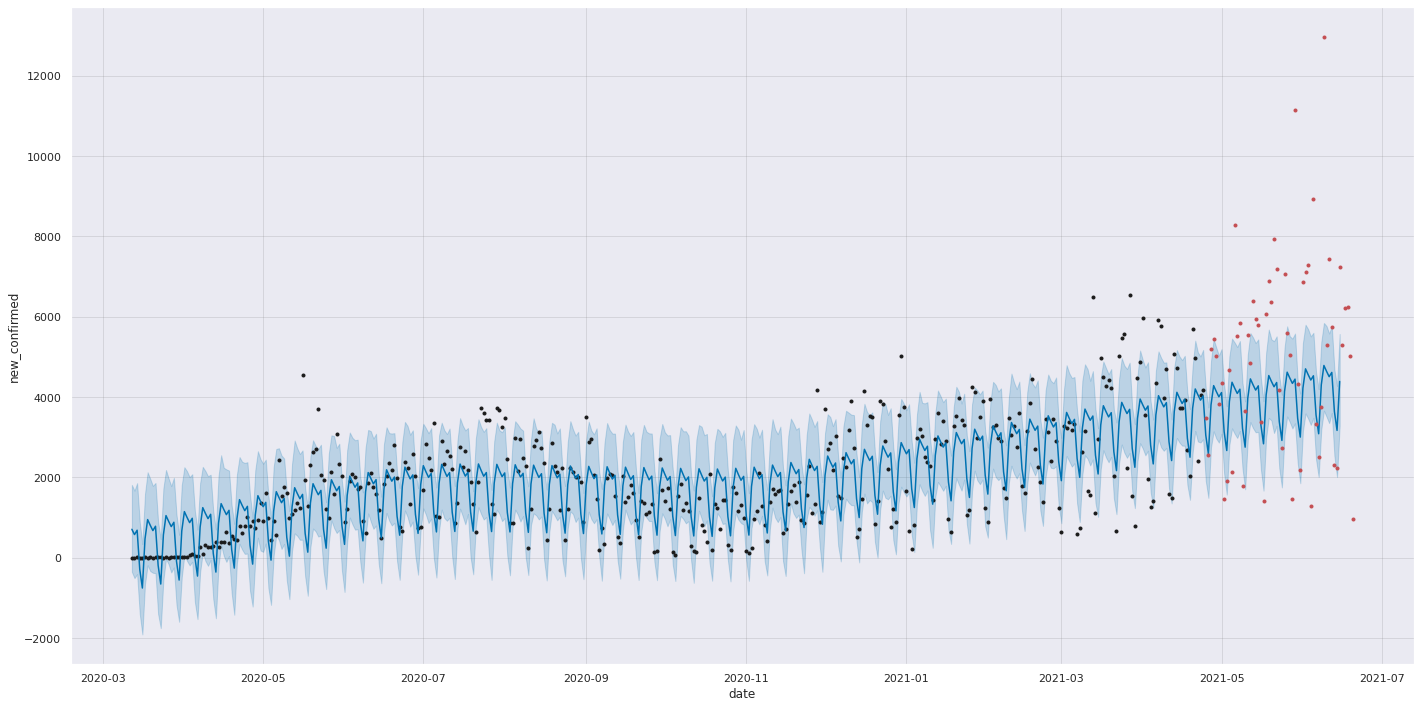

In [ ]:
# Gráfico da previsão e validação
modelo.plot(previsao, xlabel='date', ylabel='new_confirmed', figsize=(20,10));
plt.plot(df_valid['ds'], df_valid['y'], '.r')

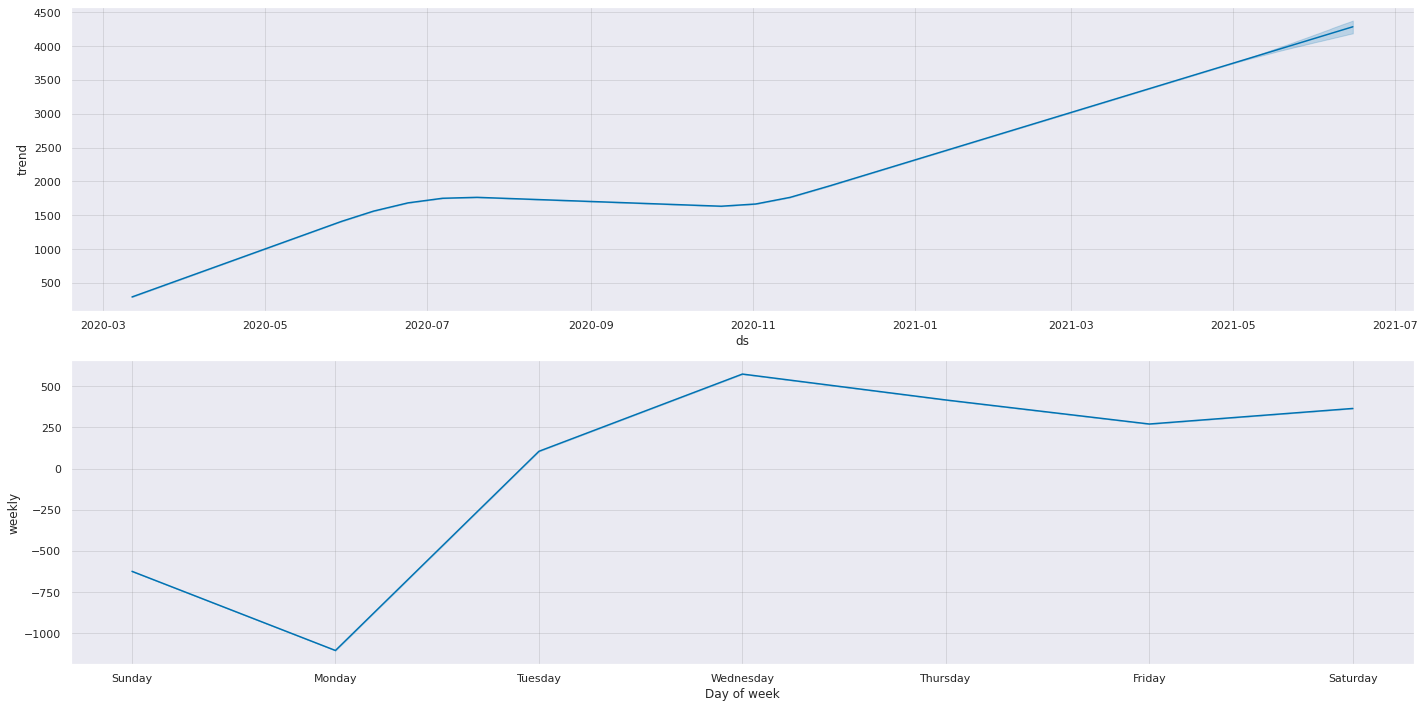

In [ ]:
modelo.plot_components(previsao, figsize=(20,10));

Como podemos ver, este modelo de previsão não é muito aderente aos dados de validação. Além disso, o modelo indica a tendência semanal que observamos nos gráficos de abril e maio de 2021, mas não há indicadores dos feriados. Deste modo, iremos trabalhar com mais alguns parâmetros do Prophet para que nosso modelo fique cada vez melhor.

## **3.3.2. Melhorando o modelo de previsão**

Vamos começar adicionando marcadores significativos (changepoints) no gráfico de previsão do Prophet.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


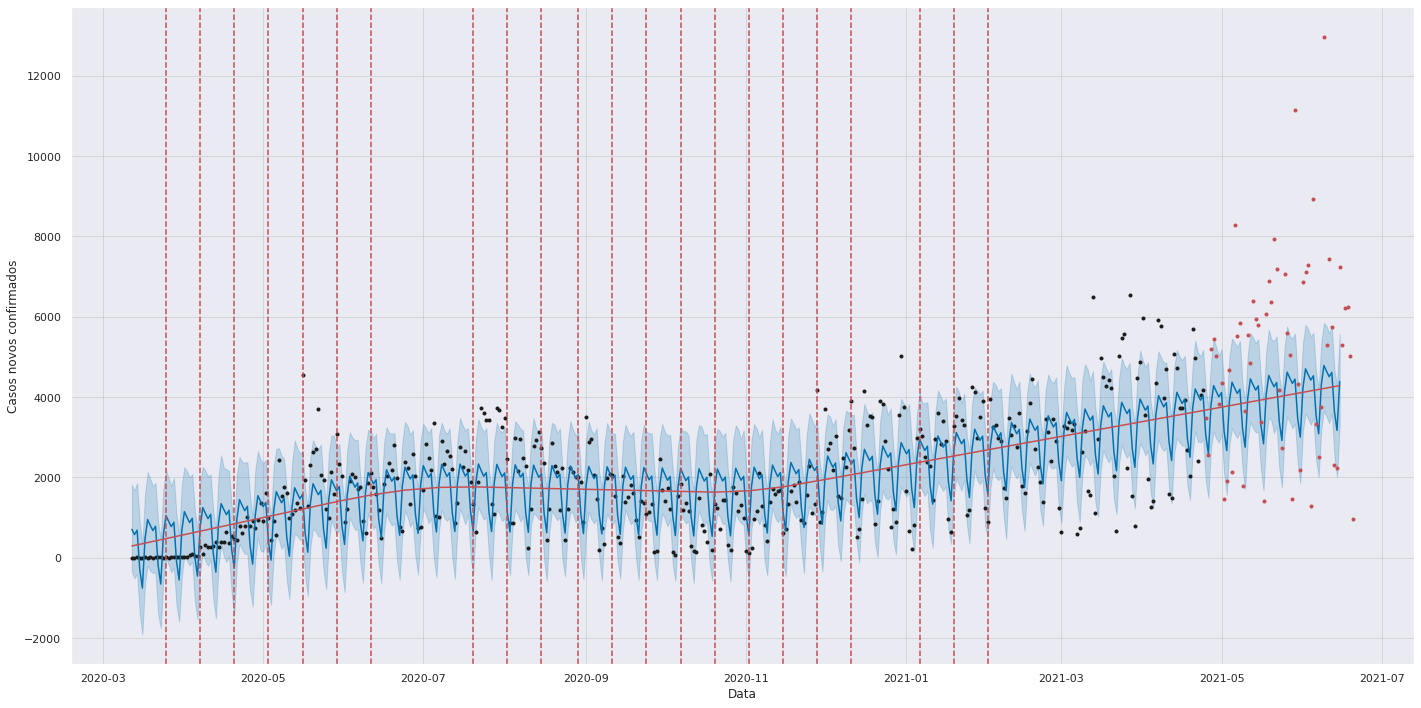

In [ ]:
# Modelo dos dados de treino com os changepoints
modelo = Prophet(changepoint_prior_scale=10)
modelo.fit(df_treino)

# Gráfico da previsão e validação com visualização dos changepoints
fig = modelo.plot(previsao, xlabel='Data', ylabel='Casos novos confirmados', figsize=(20,10));
plt.plot(df_valid['ds'], df_valid['y'], '.r')
a = add_changepoints_to_plot(fig.gca(), modelo, previsao)

As linhas vermelhas no gráfico acima são os changepoints: lista de datas nas quais são incluidos pontos de mudança em potencial.

Agora precisamos adicionar os feriados ao nosso modelo. Vamos começar apenas com os feriados nacionais:

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


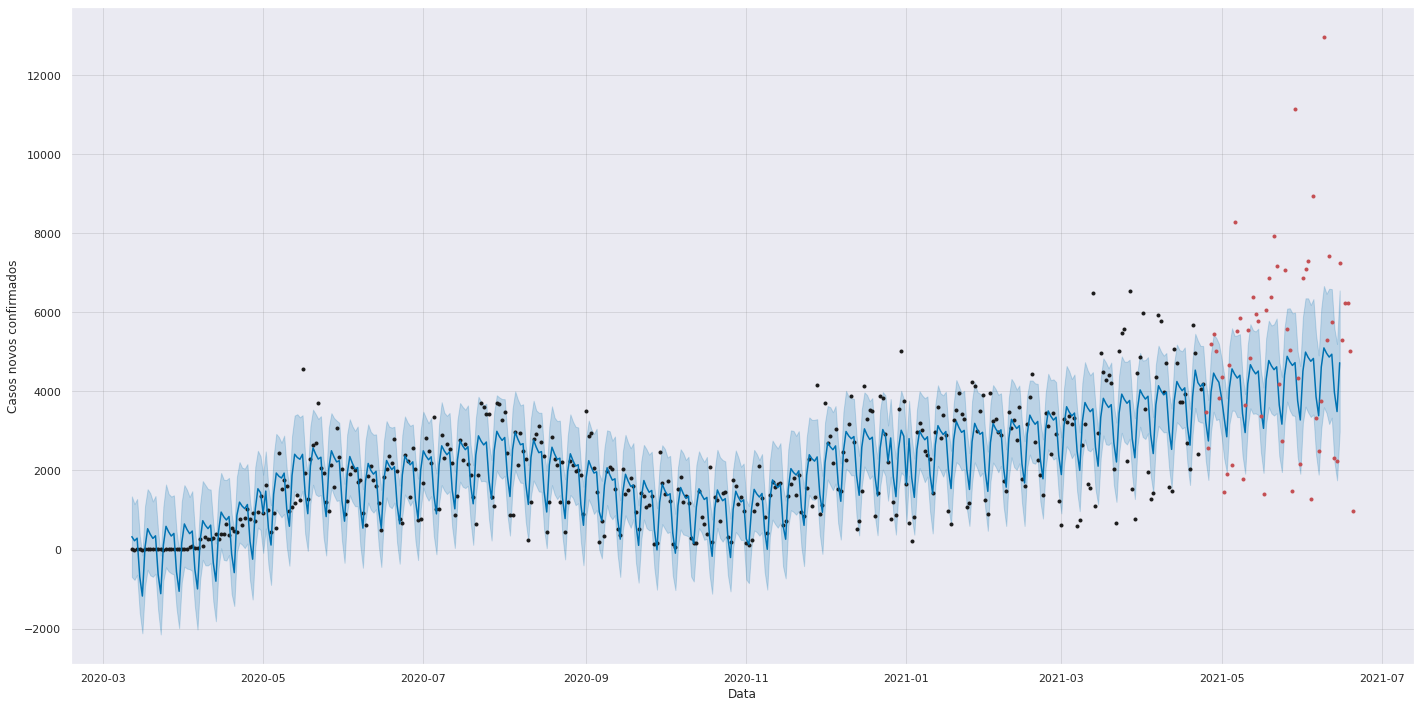

In [ ]:
# Modelo dos dados de treino
modelo = Prophet(changepoint_prior_scale=10)
modelo.add_country_holidays(country_name='BR')
modelo.fit(df_treino)

# Dataframe de previsão dos dados de treino
dataframefuturo = modelo.make_future_dataframe(periods=52)
previsao = modelo.predict(dataframefuturo)

# Gráfico da previsão e validação com os changepoints e feriados nacionais
modelo.plot(previsao, xlabel='Data', ylabel='Casos novos confirmados', figsize=(20,10));
plt.plot(df_valid['ds'], df_valid['y'], '.r')

Podemos já ver uma mudança no nosso modelo de previsão. Percebemos no gráfico acima uma variação, em pontos específicos, na ondulação da série temporal. O prophet está adicionando um ponto extra onde ele consegue se ajustar melhor a um desses pontos específicos, justamente por termos adicionado os feriados do Brasil como informação. No entanto, precisamos considerar os feriados estaduais, de Pernambuco.

## **3.3.3. Inserindo os feriados de PE**

Vamos criar nosso próprio string de feriados, incluindo todos feriados ocorridos no PE nos meses registrados no banco de dados de treino (março de 2020 a abril 2021). Os feriados aqui informados foram extráidos do site: www.feriados.com.br

In [ ]:
# Feriados do PE de 2020
feriados_pe_2020= [
'2020-04-01',
'2020-04-10',
'2020-04-12',
'2020-04-21',
'2020-05-01',
'2020-05-10',
'2020-06-11',
'2020-06-12',
'2020-06-24',
'2020-08-09',
'2020-09-07',
'2020-10-12',
'2020-10-15',
'2020-10-17',
'2020-10-28',
'2020-11-02',
'2020-11-15',
'2020-11-20',
'2020-12-25'
]

In [ ]:
# Feriados do PE de 2021
feriados_pe_2021= [
'2021-01-01',
'2021-02-15',
'2021-02-16',
'2021-02-17',
'2021-03-06',
'2021-04-01',
'2021-04-02',
'2021-04-04',
'2021-04-21'
]

Criando um df com a coluna dos feriados que queremos adicionar

In [ ]:
# Criando df dos feriados do PE em 2020
feriados_pe_2020 = pd.DataFrame({'holiday': 'pe_2020', 
                                 'ds': pd.to_datetime(feriados_pe_2020)})
# Criando df dos feriados do PE em 2021
feriados_pe_2021 = pd.DataFrame({'holiday': 'pe_2021', 
                                 'ds': pd.to_datetime(feriados_pe_2021)})

# Concatenando os dfs dos feriados de 2020 e 2021
feriados = pd.concat((feriados_pe_2020, feriados_pe_2021))

Criando nosso modelo com os novos feriados

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


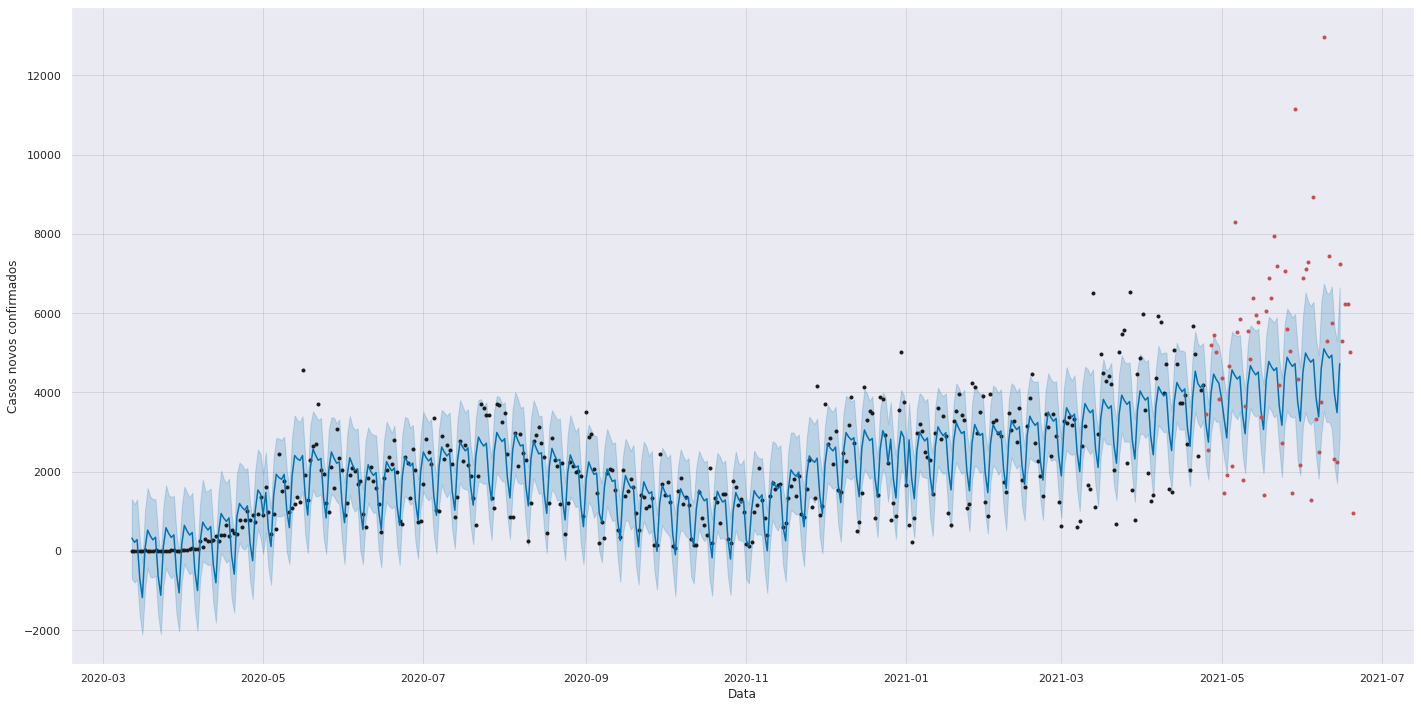

In [ ]:
# Modelo dos dados de treino com os feriados do PE
modelo_feriados = Prophet(changepoint_prior_scale=10.0, holidays=feriados)
modelo_feriados.fit(df_treino)

# Dataframe de previsão dos dados de treino
dataframefuturo = modelo_feriados.make_future_dataframe(periods=52)
previsao = modelo.predict(dataframefuturo)

# Gráfico da previsão e validação com os changepoints e feriados do PA
modelo_feriados.plot(previsao, xlabel='Data', ylabel='Casos novos confirmados', figsize=(20,10));
plt.plot(df_valid['ds'], df_valid['y'], '.r')

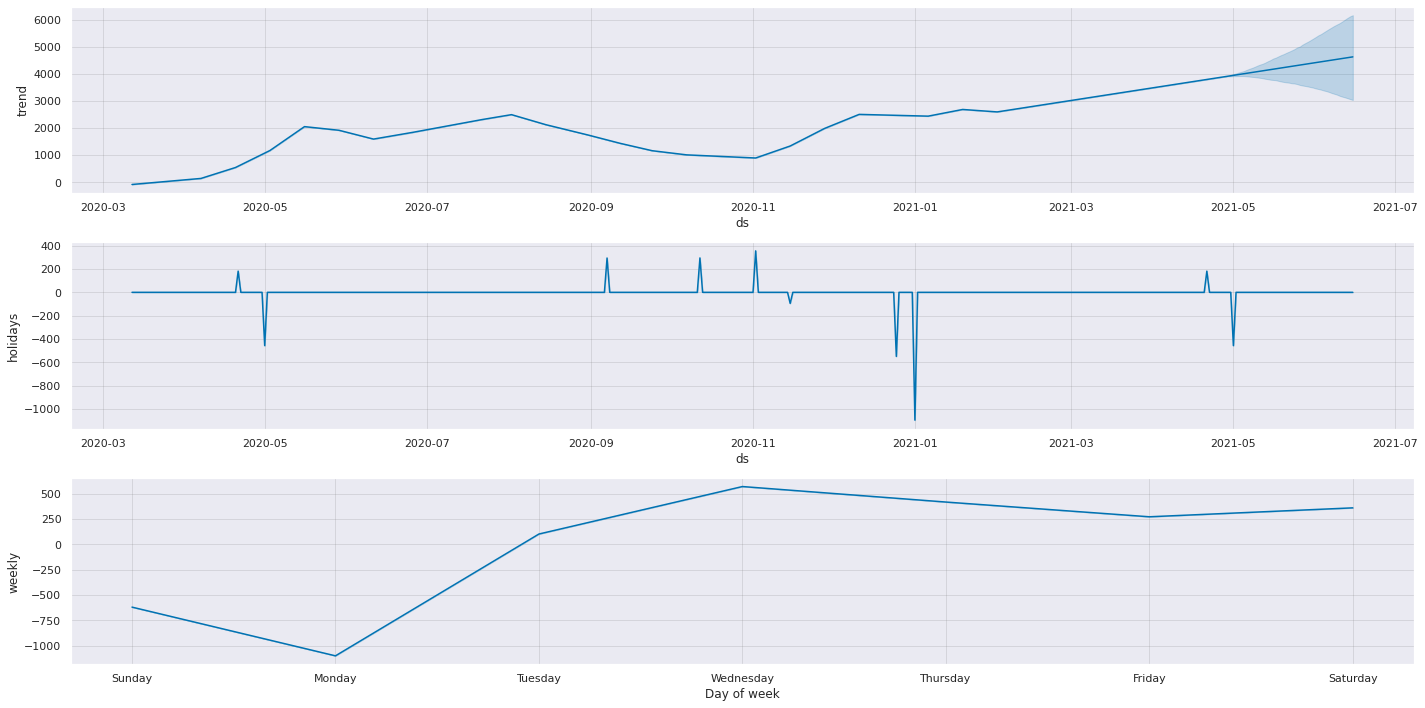

In [ ]:
# Componentes do modelo de previsão
modelo_feriados.plot_components(previsao, figsize=(20,10));

Agora que adicionamos os feriados ao nosso modelo, temos um novo componente, o componente holidays. Do contrário dos outros dois, o gráfico dos feriado não é uma tendência, é uma informação pontual que adicionamos aos dados. No gráfico de feriados nós temos picos que representam um decréscimo de número de casos notificados, como o que observamos ao analisar, indivisualmente, os gráficos de abril e maio de 2021. 

Repare que nesse gráfico o eixo y tem valores negativos entre 0 e -2000, isso representa um decréscimo de número de casos notificados devido aos feriados. Isso nos mostra que, de fato, o número de notificações de casos de COVID-19 diminui aos feriados, uma informação muito relevante que podemos interpretar a partir desse modelo.

Outra coisa que podemos perceber no gráfico desse modelo, é que, ao final do gráfico de tendência geral dos dados, temos um intervalo de confiança bem maior em relação ao primeiro modelo. Esse intervalo, atribuido na parte final da tendência, sugere as possíveis desvios dos dados futuros em relação ao modelo de previsão. O modelo não coloca nada de informação no início da série temporal porque é justamente a parte em que conhece os dados. Qualquer desvio dos dados, ele atribui ao ruído, em azul claro.

Agora que temos o indicador dos feriados, vamos analisar a média absoluta do desvio padrão dos dados de treino, o yhat do dataframe 'previsao', para verificar a aderência do nosso modelo aos dados:

In [ ]:
# Sasonalidade aditiva
mean_absolute_error(df_treino['y'], previsao['yhat'][:409])

575.4160674345029

Sabemos que, quanto mais próximo de zero for o 'mean_absolute_error' melhor será o modelo de previsão. Como nosso modelo de sasonalidade aditiva gerou um resultado de "638" para essa métrica, iremos testar a sazonalidade multiplicativa dentro do Prophet de 'modelo_feriados' e ver se o resultado melhora (se aproxima mais do zero), ou piora.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


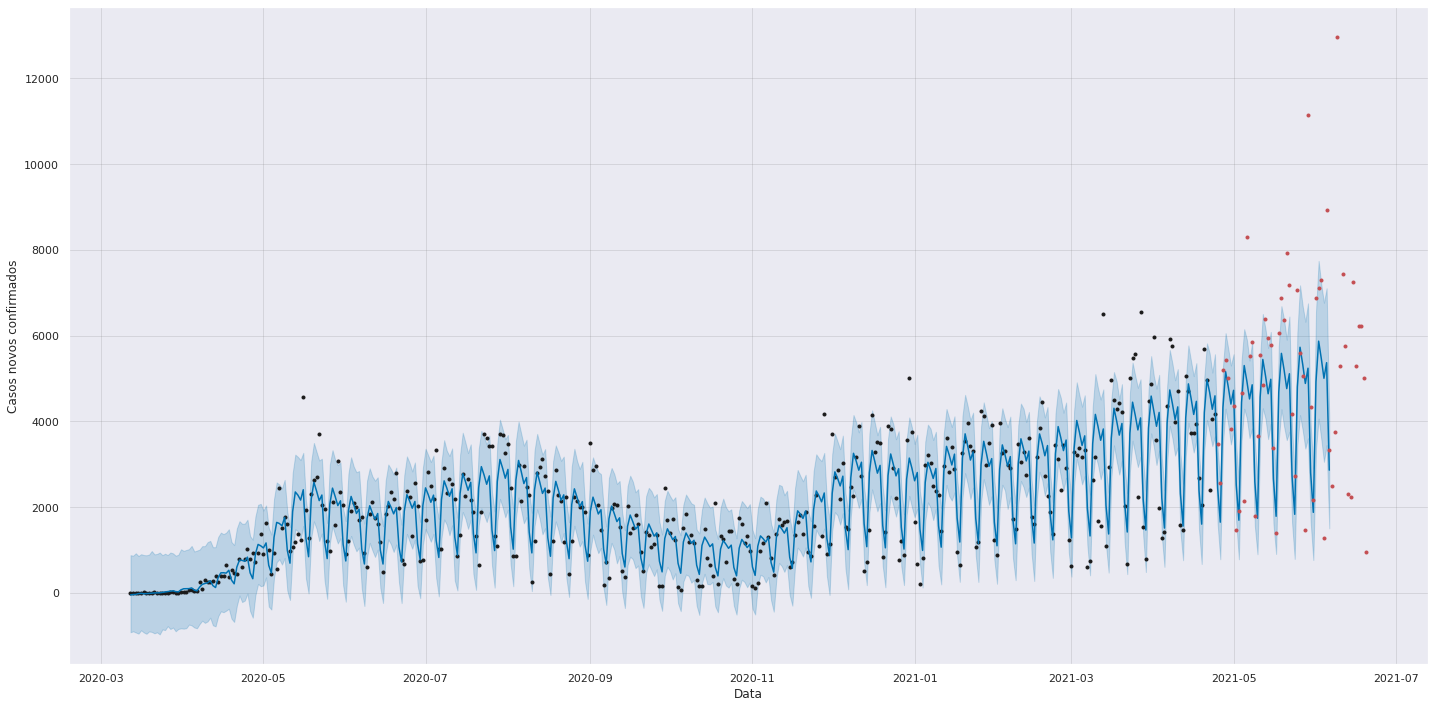

In [ ]:
# Modelo dos dados de treino, com os feriados do PA
# adicionamos o 'seasonality_mode' a fim de melhorar o modelo de previsão
modelo_feriados = Prophet(changepoint_prior_scale=10.0, holidays=feriados, seasonality_mode='multiplicative')
modelo_feriados.fit(df_treino)

# Dataframe de previsão dos dados de treino
dataframefuturo = modelo_feriados.make_future_dataframe(periods=43)
previsao = modelo_feriados.predict(dataframefuturo)

# Gráfico da previsão e validação com os changepoints e feriados do PE
modelo_feriados.plot(previsao, xlabel='Data', ylabel='Casos novos confirmados', figsize=(20,10));
plt.plot(df_valid['ds'], df_valid['y'], '.r')

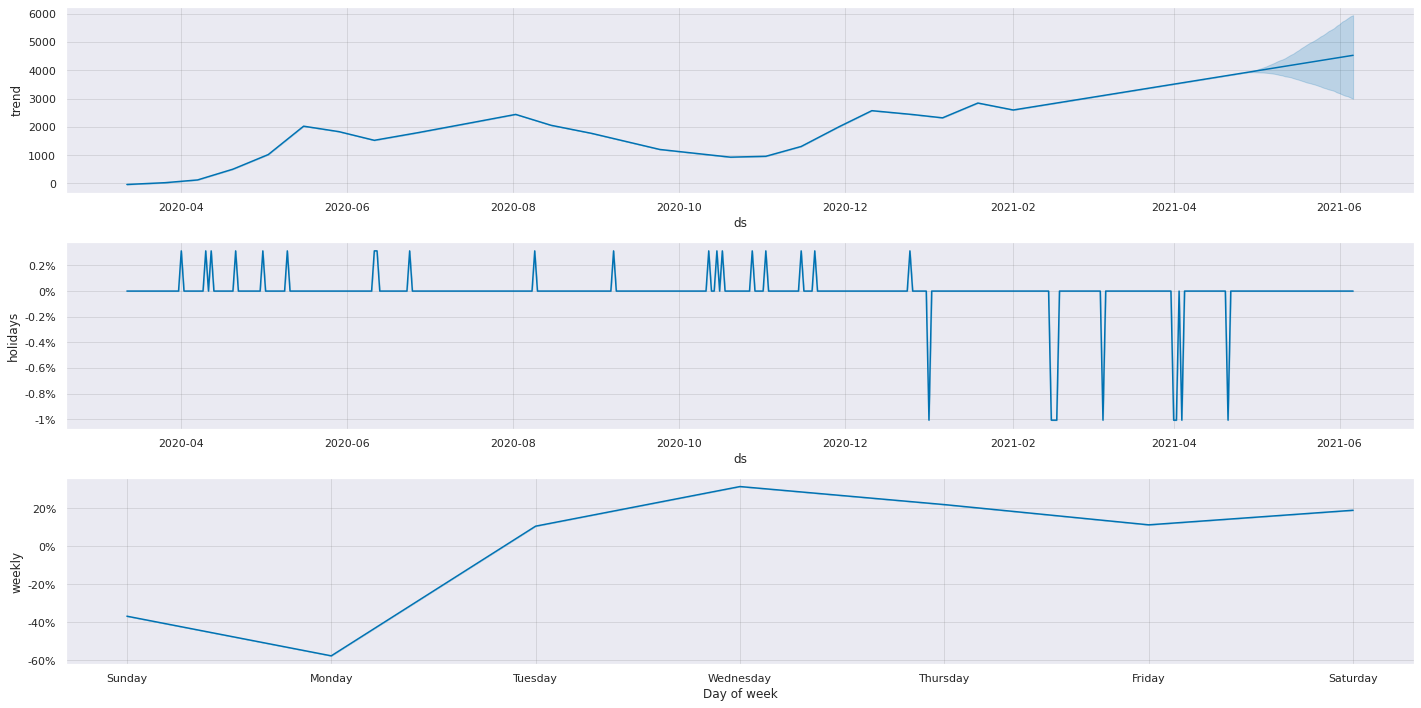

In [ ]:
# Componentes do modelo de previsão
modelo_feriados.plot_components(previsao, figsize=(20,10));

In [ ]:
# Sasonalidade multiplicativa
mean_absolute_error(df_treino['y'], previsao['yhat'][:409])

491.9596948518714

Como podemos ver acima, nosso modelo de previsão melhorou. no gráfico do meodelo multiplicativo de previsão previu melhor os dados de validação (pontos vermelhos) em comparação ao modelo normal. Além disso, o valor do 'mean_absolute_error' diminuiu dráticamente, se aproximando mais do zero.

# **3.4. Outliers e validação**

Para finalizar nosso modelo, nos resta remover os outliers do banco de dados e validá-lo 

## **3.4.1. Remoção de outliers**

Vamos começar removendo os outliers do nosso dataframe de casos novos para ver se conseguimos melhorar nosso modelo de previsão

In [ ]:
# Add index em df
novo_y = df_treino.reset_index()
novo_y.head()

,index,ds,y
0,0,2020-03-12,4
1,1,2020-03-13,0
2,2,2020-03-14,10
3,3,2020-03-15,2
4,4,2020-03-16,0


In [ ]:
# Removendo outliers do dataframe de previsao
sem_outliers = novo_y[(novo_y['y']> previsao['yhat_lower'][:409]) & (novo_y['y'] < previsao['yhat_upper'][:409])]
sem_outliers.head()

,index,ds,y
0,0,2020-03-12,4
1,1,2020-03-13,0
2,2,2020-03-14,10
3,3,2020-03-15,2
4,4,2020-03-16,0


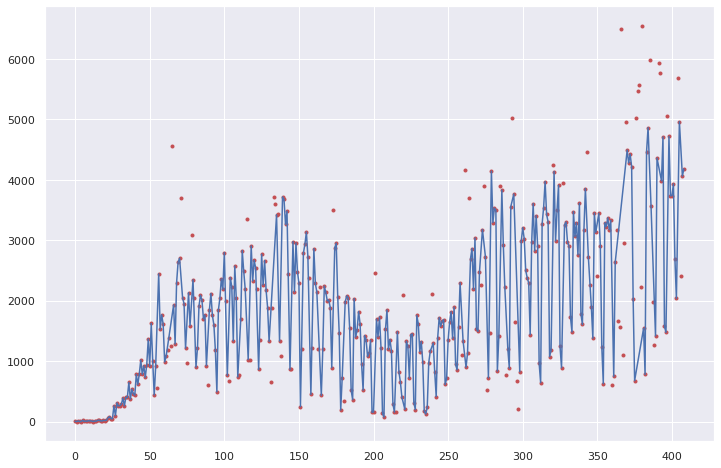

In [ ]:
plt.plot(df_treino.index, df_treino['y'], 'r.')
plt.plot(sem_outliers['index'], sem_outliers['y'])

O gráfico acima nos mostra, em vermelho, os dados originais. A linha azul indica os pontos que não são outliers. Pontos vemelhos não ligados à linha azul são os outliers que iremos remover do modelo de previsão.

In [ ]:
# Novo df sem outliers
df_sem_outliers = sem_outliers[['ds','y']]
df_sem_outliers.head()

,ds,y
0,2020-03-12,4
1,2020-03-13,0
2,2020-03-14,10
3,2020-03-15,2
4,2020-03-16,0


## **3.4.2. Modelo final de previsão**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


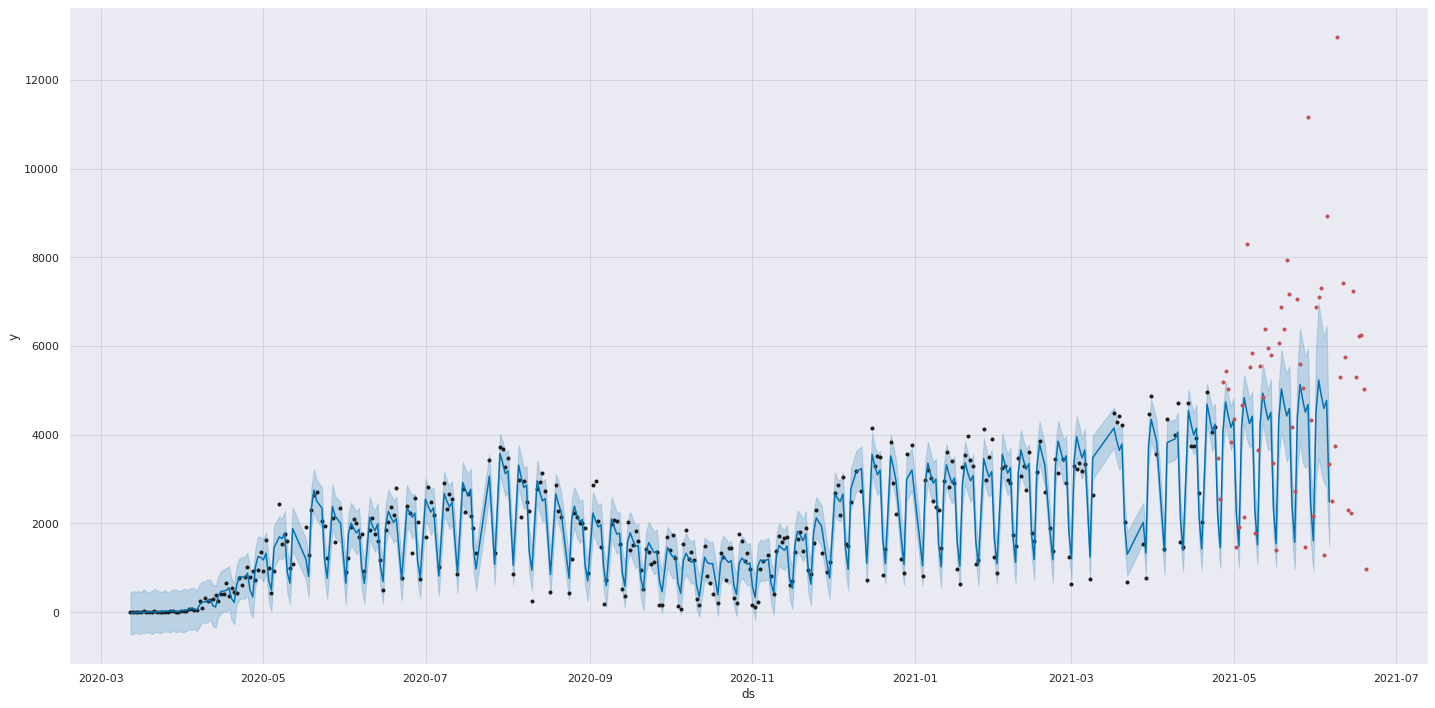

In [ ]:
# Modelo dos dados de treino, com os feriados do PE
modelo_feriados = Prophet(changepoint_prior_scale=10.0, holidays=feriados, seasonality_mode='multiplicative')
modelo_feriados.fit(df_sem_outliers)

# Dataframe de previsão dos dados de treino
dataframefuturo = modelo_feriados.make_future_dataframe(periods=43)
previsao = modelo_feriados.predict(dataframefuturo)

# Gráfico da previsão e validação com os changepoints e feriados do PE
fig = modelo_feriados.plot(previsao, figsize=(20,10));
plt.plot(df_valid['ds'], df_valid['y'], '.r')

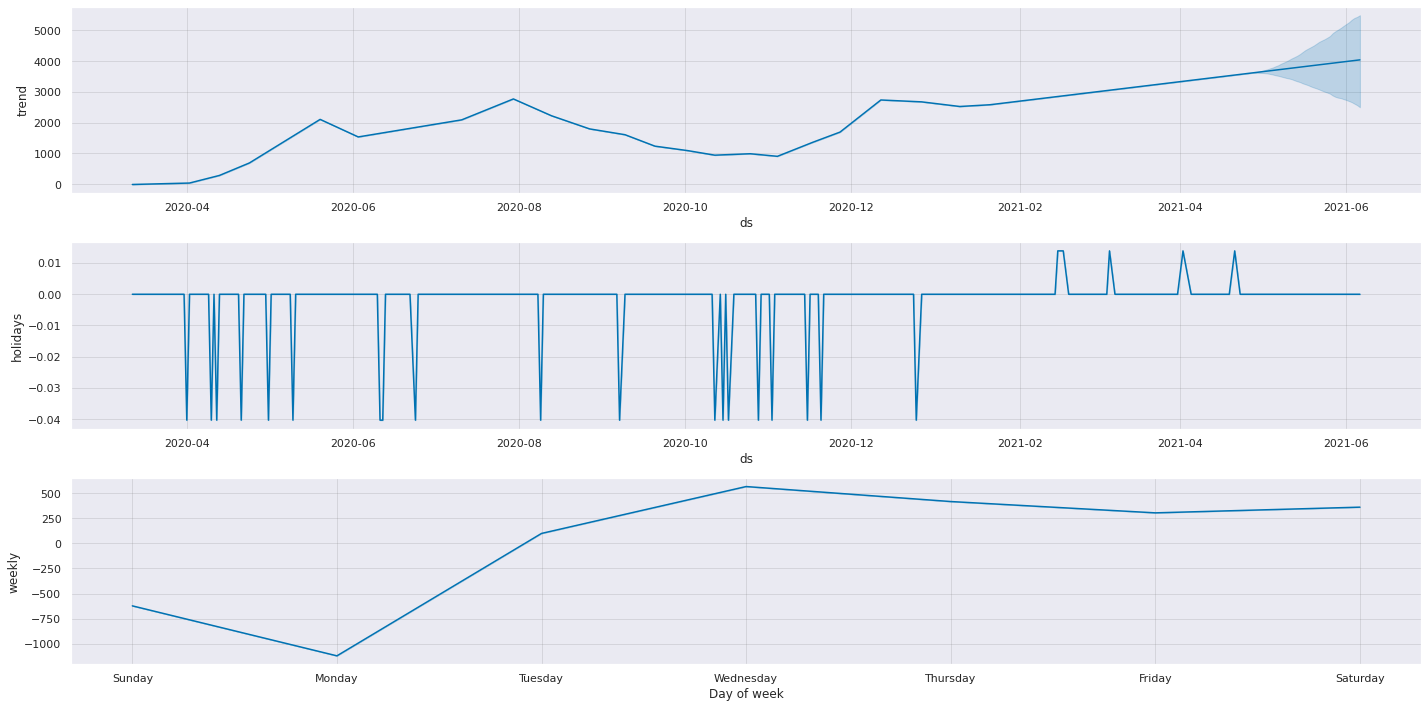

In [ ]:
# Componentes do modelo de previsão
modelo.plot_components(previsao, figsize=(20,10));

## **3.4.3. Validando o modelo de previsão**

Por fim, iremos utilizar a ferramenta "cross_validation" [[2]](https://scikit-learn.org/stable/modules/cross_validation.html) para validar nosso modelo de previsao e verificar se não realizamos overfitting.

In [ ]:
# df de validação cruzada
df_cv = cross_validation(modelo_feriados, initial='180 days', period='30 days', horizon='30 days')
df_cv.head()

INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-09-26 00:00:00 and 2021-03-25 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-09-27,914.236075,522.287601,1270.279865,152,2020-09-26
1,2020-09-28,437.261710,72.395586,817.002898,160,2020-09-26
2,2020-09-30,1207.762329,822.231471,1599.170744,1692,2020-09-26
3,2020-10-01,1165.647085,742.888418,1554.978978,1402,2020-09-26
4,2020-10-02,1090.520111,687.825744,1551.427583,1730,2020-09-26


Para visualizarmos as operações do cross_validation, considere o plot abaixo. Temos nos gráficos nossa série temporal, com os pontos pretos sendo os nossos dados de treino. Além disso temos uma linha cinza vertical, plotada em um determinado ponto do gráfico, uma série temporal em linha azul-escura, e uma região de intervalo de confiança em torno dessa linha em azul-claro.

A linha azul-escura e o intervalo de confiança se referem ao trecho que foi usado para teste. Ele utilizou todos os pontos pretos anteriores à linha vertical cinza para treinar um modelo de série temporal, e depois, pegou o trecho azul e utilizou para teste do modelo. Ou seja, ao mover nossa janela para frente, alterando seu tamanho para um valor maior, ele pegará todos os pontos anteriores à linha cinza, e da janela para frente, como uma janela de testes para validar os resultados. A ideia é validar nosso modelo com diversos exemplos.

In [ ]:
lista_cutoff = df_cv['cutoff'].unique()

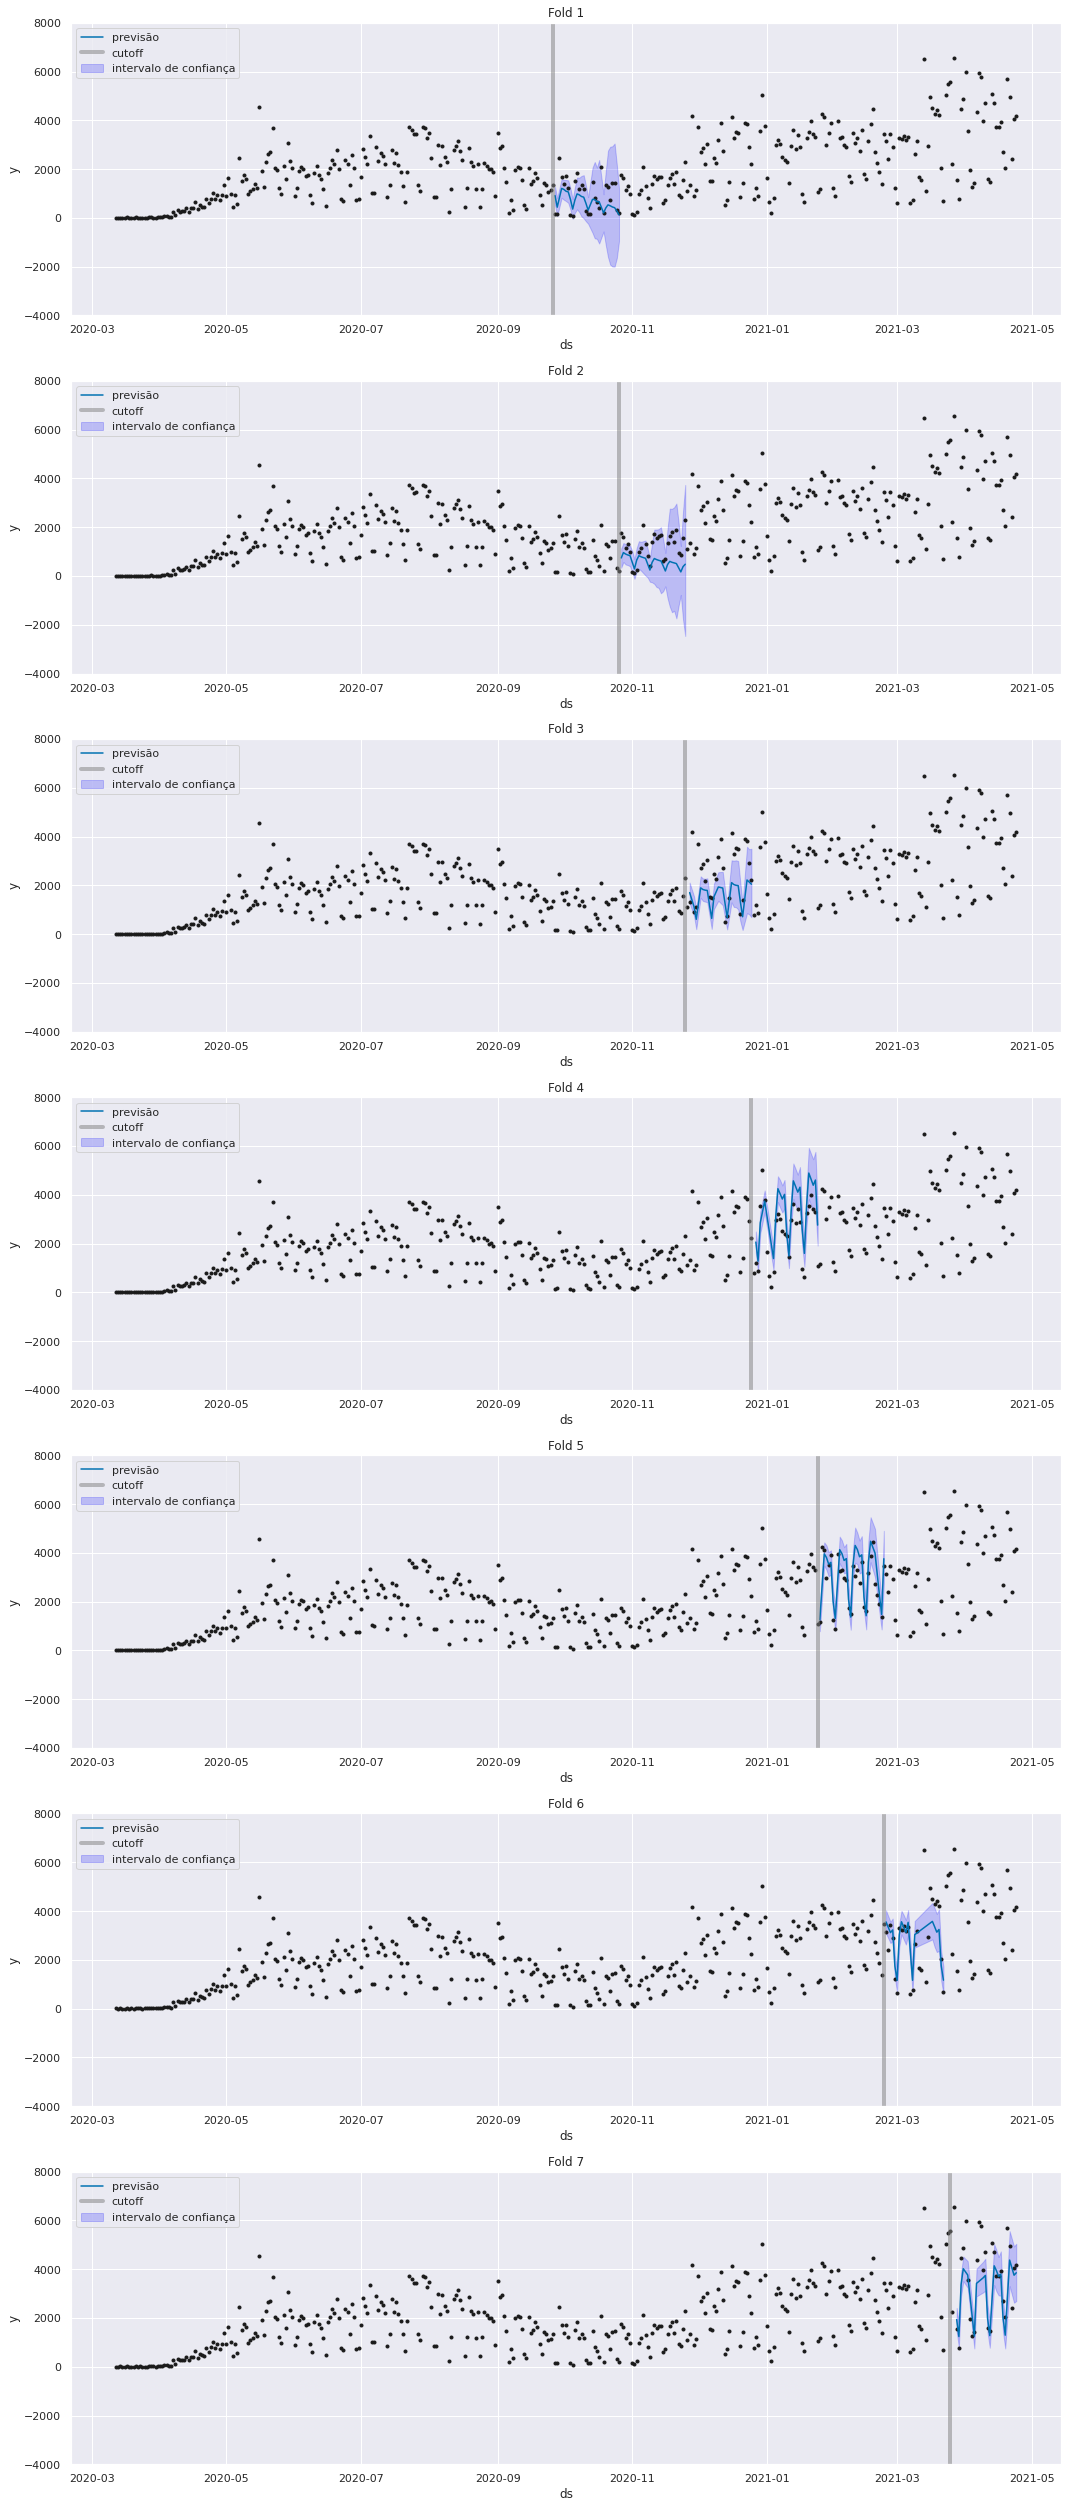

In [ ]:
fig, axs = plt.subplots(len(lista_cutoff), 1, figsize=(15,35))

for ind, cutoff in enumerate(lista_cutoff):

    df_cv_cut = df_cv[df_cv['cutoff'].values == cutoff]
   
    axs[ind].plot(modelo.history['ds'].values, modelo.history['y'], 'k.')

    axs[ind].plot(df_cv_cut['ds'].values, df_cv_cut['yhat'], ls='-', c='#0072B2', label='previsão')
    
    axs[ind].fill_between(df_cv_cut['ds'].values, df_cv_cut['yhat_lower'],
                    df_cv_cut['yhat_upper'], color='blue',
                    alpha=0.2, label='intervalo de confiança')
    
    axs[ind].axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5, label='cutoff')
    
    axs[ind].set_title(f'Fold {ind + 1}')
    axs[ind].set_ylabel('y')
    axs[ind].set_xlabel('ds')
    axs[ind].legend(loc=2)

    axs[ind].set_ylim(-4000, 8000)
fig.tight_layout()
plt.show()

As séries temporais são sequenciais. O Cross Validation (validação cruzada) é a forma adotada pelo Prophet para validar modelos de previsão para dados sequenciais.

In [ ]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,4 days,2.413808e+05,491.305170,448.139038,0.389395,0.273933,0.562500
1,5 days,2.570315e+05,506.982718,435.055206,0.259048,0.250876,0.500000
2,6 days,2.872665e+05,535.972482,454.375651,0.401814,0.247126,0.446429
3,7 days,2.825212e+05,531.527187,438.951903,0.467882,0.270754,0.531250
4,8 days,2.925607e+05,540.888772,466.387800,0.810778,0.327981,0.593750
5,9 days,2.397382e+05,489.630718,404.985499,0.914267,0.235691,0.718750
6,10 days,3.508090e+05,592.291312,485.616514,0.858766,0.341088,0.625000
7,11 days,3.158446e+05,562.000534,443.299991,0.469602,0.214419,0.625000
8,12 days,4.533076e+05,673.281249,582.622539,0.286631,0.232720,0.458333
9,13 days,4.812981e+05,693.756478,624.238289,0.316972,0.330363,0.479167


Por fim, iremos utilizar a ferramenta "cross_validation" [[2]](https://scikit-learn.org/stable/modules/cross_validation.html) para validar nosso modelo de previsao e verificar se não realizamos overfitting dos dados.

In [ ]:
# df de validação cruzada
df_cv = cross_validation(modelo_feriados, initial='180 days', period='30 days', horizon='30 days')
df_cv.head()

INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-09-26 00:00:00 and 2021-03-25 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-09-27,914.236075,522.923643,1279.004855,152,2020-09-26
1,2020-09-28,437.261710,51.019085,798.601330,160,2020-09-26
2,2020-09-30,1207.762329,801.979015,1601.284056,1692,2020-09-26
3,2020-10-01,1165.647085,742.250759,1579.226174,1402,2020-09-26
4,2020-10-02,1090.520111,634.920651,1529.108060,1730,2020-09-26


Para visualizarmos as operações do cross_validation, considere o plot abaixo. Temos nos gráficos nossa série temporal, com os pontos pretos sendo os nossos dados de treino. Além disso temos uma linha cinza vertical, plotada em um determinado ponto do gráfico, uma série temporal em linha azul-escura, e uma região de intervalo de confiança em torno dessa linha em azul-claro.

A linha azul-escura e o intervalo de confiança simbolizam o trecho utilizado para teste. O CV utilizou todos os pontos pretos anteriores à linha vertical cinza para treinar um modelo de série temporal, e depois, pegou o trecho azul e utilizou para teste do modelo. A ideia do CV é validar nosso modelo em diversos cutoffs.

In [ ]:
lista_cutoff = df_cv['cutoff'].unique()

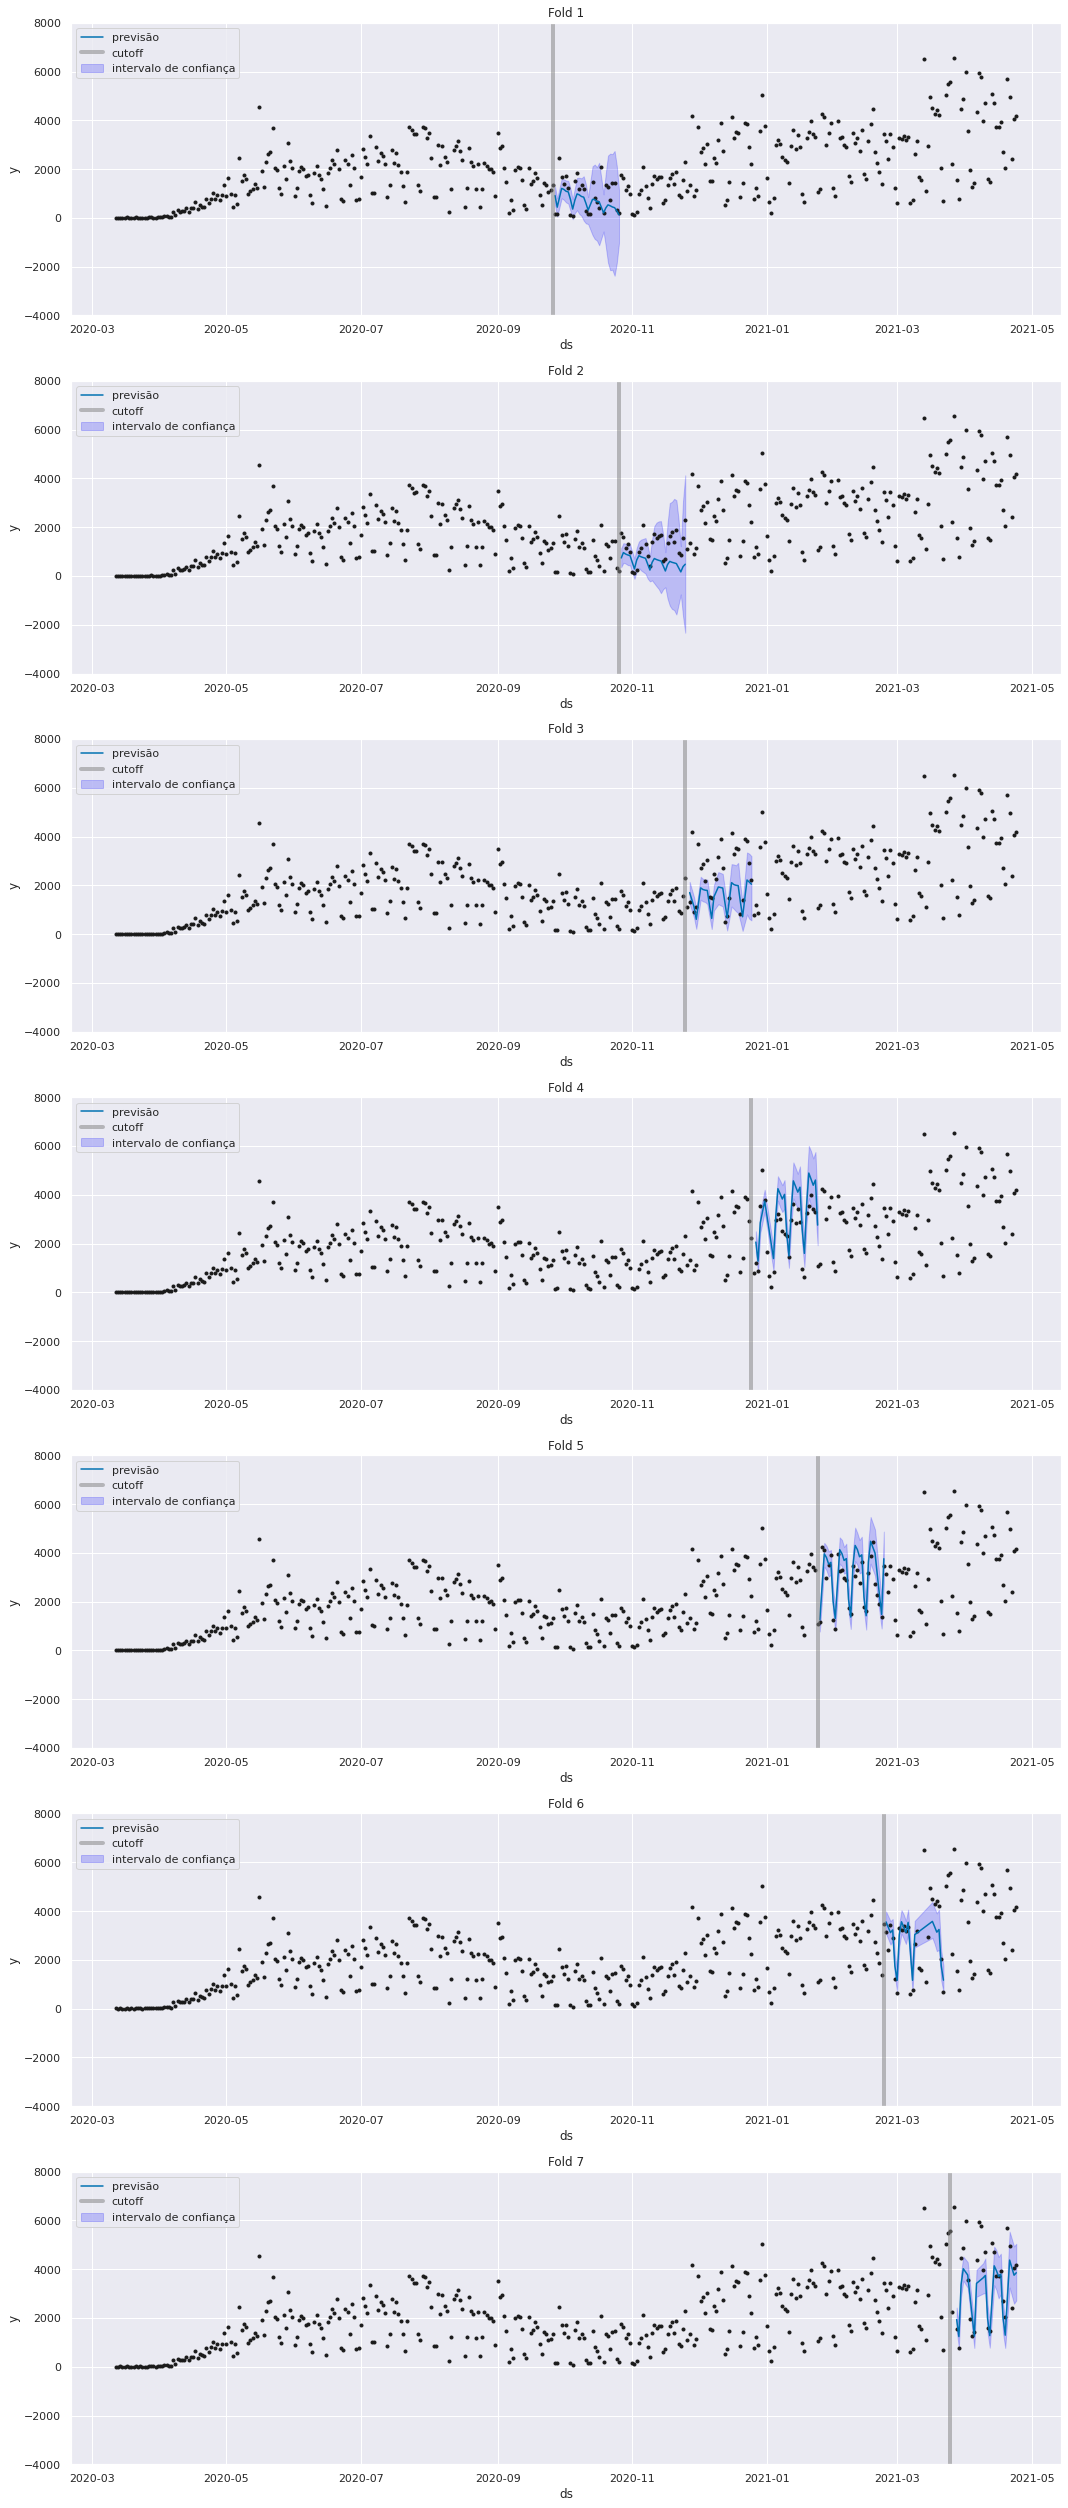

In [ ]:
fig, axs = plt.subplots(len(lista_cutoff), 1, figsize=(15,35))

for ind, cutoff in enumerate(lista_cutoff):

    df_cv_cut = df_cv[df_cv['cutoff'].values == cutoff]
   
    axs[ind].plot(modelo.history['ds'].values, modelo.history['y'], 'k.')

    axs[ind].plot(df_cv_cut['ds'].values, df_cv_cut['yhat'], ls='-', c='#0072B2', label='previsão')
    
    axs[ind].fill_between(df_cv_cut['ds'].values, df_cv_cut['yhat_lower'],
                    df_cv_cut['yhat_upper'], color='blue',
                    alpha=0.2, label='intervalo de confiança')
    
    axs[ind].axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5, label='cutoff')
    
    axs[ind].set_title(f'Fold {ind + 1}')
    axs[ind].set_ylabel('y')
    axs[ind].set_xlabel('ds')
    axs[ind].legend(loc=2)

    axs[ind].set_ylim(-4000, 8000)
fig.tight_layout()
plt.show()

Além disso, podemos calcular as Métricas de Performance (MP) do nosso modelo de previsão. A MP pode ser usada para calcular algumas estatísticas úteis do desempenho da previsão (yhat, yhat_lower e yhat_upper em comparação com y), como uma função da distância do cutoff (quão longe no futuro estava a previsão). As estatísticas calculadas são: mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE), median absolute percent error (MDAPE) e coverage das estimativas do yhat_lower e yhat_upper [[3]](https://facebook.github.io/prophet/docs/diagnostics.html). De um modo geral, todas essas métricas abaixo nos mostram a medida do erro, em função do número de dias, da nossa previsão.

In [ ]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,4 days,2.413808e+05,491.305170,448.139038,0.389395,0.273933,0.625000
1,5 days,2.570315e+05,506.982718,435.055206,0.259048,0.250876,0.562500
2,6 days,2.872665e+05,535.972482,454.375651,0.401814,0.247126,0.482143
3,7 days,2.825212e+05,531.527187,438.951903,0.467882,0.270754,0.531250
4,8 days,2.925607e+05,540.888772,466.387800,0.810778,0.327981,0.593750
5,9 days,2.397382e+05,489.630718,404.985499,0.914267,0.235691,0.718750
6,10 days,3.508090e+05,592.291312,485.616514,0.858766,0.341088,0.625000
7,11 days,3.158446e+05,562.000534,443.299991,0.469602,0.214419,0.625000
8,12 days,4.533076e+05,673.281249,582.622539,0.286631,0.232720,0.458333
9,13 days,4.812981e+05,693.756478,624.238289,0.316972,0.330363,0.479167


Para nossa serie temporal, a métrica mais adequada para validar nosso modelo de previsão é a RMSE [[4]](https://paulovasconcellos.com.br/como-saber-se-seu-modelo-de-machine-learning-est%C3%A1-funcionando-mesmo-a5892f6468b). Deste modo, iremos realizar o plot dessa métrica para avaliar a precisão da nossa previsão futura em função do tempo (dias).

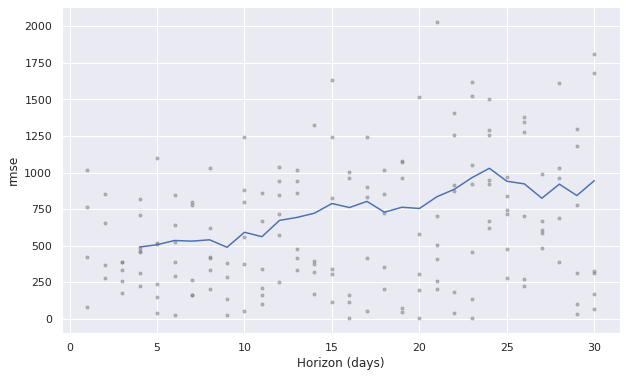

In [ ]:
# Plot da Raiz Quadrada do Erro Quadrático Médio:
plot_cross_validation_metric(df_cv,metric='rmse');

Como podemos ver acima, a média do erro da nossa previsão futura (linha azul escura) aumenta nos primeros 15 dias, ou seja, diminui sua precisão. Em seguida o erro é praticamente constante durante 5 dias e, novamente, aumente durante mais 5 dias, até que diminui e se torna mais constante nos últimos 5 dias. Dito isso, podemos considerar que nosso modelo de machine leraning tem uma boa chance de acertar suas previsões temporais.

# **Referências**

1. https://brasil.io/dataset/covid19/caso_full/ (Acesso em 02 de julho de 2021)
2. https://scikit-learn.org/stable/modules/cross_validation.html (Acesso em 06 de julho de 2021, as 08:15)
3. https://facebook.github.io/prophet/docs/diagnostics.html (Acesso em 06 de julho de 2021, as 08:15)